In [1]:
import os
import sys
# Configuration des variables d'environnement Python
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


# Configurez la variable d'environnement HADOOP_HOME

os.environ["HADOOP_HOME"] = r"C:\\hadoop"
os.environ["PATH"] = os.environ["HADOOP_HOME"] + r"\bin;" + os.environ["PATH"]

In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
        .appName("MLTraining")
        .config("spark.driver.memory", "6g")
        .config("spark.executor.memory", "6g")
        .config("spark.memory.offHeap.enabled", "true")
        .config("spark.memory.offHeap.size", "2g")
        .config("spark.executor.cores", "2")
        .config("spark.driver.maxResultSize", "2g")
        .getOrCreate()
)



print(f"Spark version {spark.version}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/21 10:02:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version 3.5.1


In [3]:
data= spark.read.csv("/workspace/data/raw/DataCoSupplyChainDataset.csv",header=True,inferSchema=True)

In [4]:
data.show()

25/11/21 10:02:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sale

In [5]:
feature=[
    "Days for shipment (scheduled)",
    "Order Region",
    "Sales",
    "Order Item Quantity",
    "Order Item Profit Ratio",
    "Order City",
    "Latitude",
    "Longitude",
    "Customer Segment",
    "Category Name",
    "Sales per customer"
]

predict="Late_delivery_risk"


In [6]:
numeric_to_check = ["Sales per customer" ,"Sales", "Order Item Quantity","Order Item Profit Ratio","Latitude","Longitude" ]

numeric_df = data.select(numeric_to_check)

# Convert to Pandas (for plotting)
numeric_pd = numeric_df.toPandas()

25/11/21 10:02:41 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
                                                                                

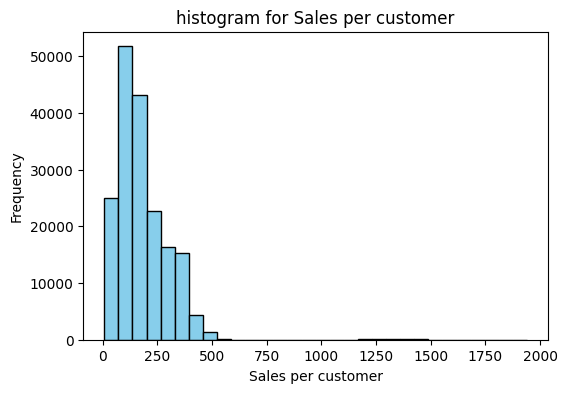

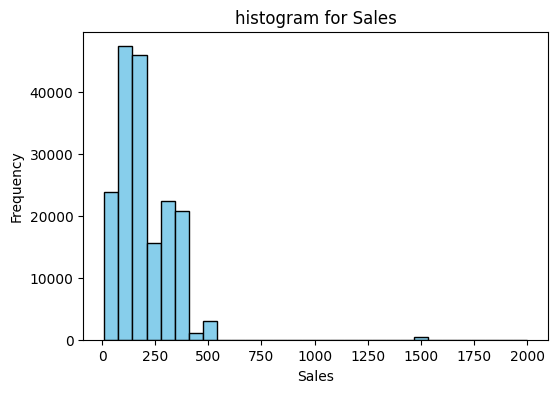

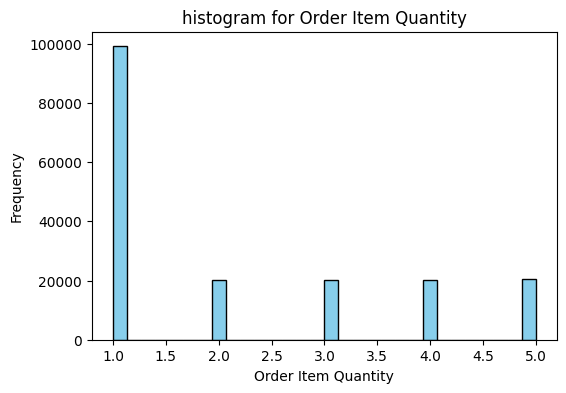

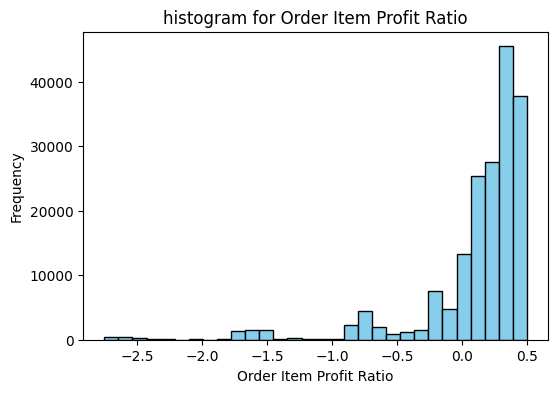

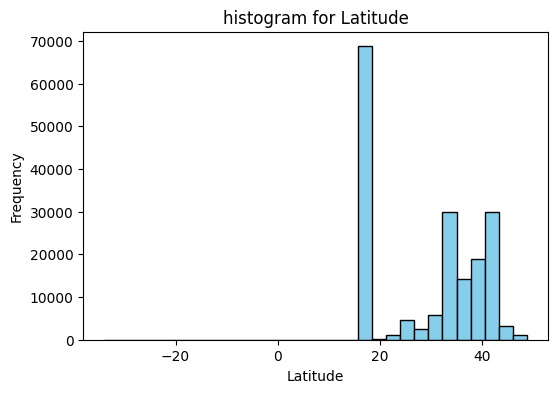

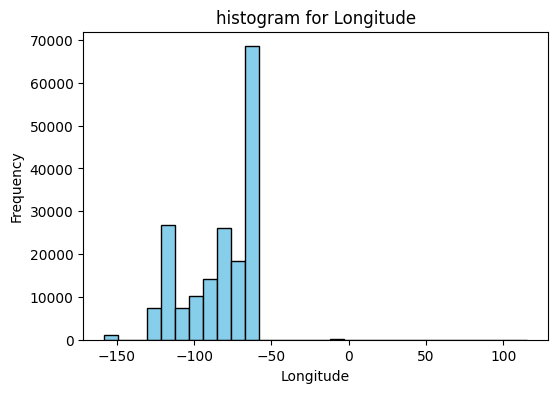

In [7]:
import matplotlib.pyplot as plt

for col in numeric_to_check : 
    plt.figure(figsize=(6,4))
    plt.hist(numeric_pd[col] , bins = 30 , color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.title(f"histogram for {col}")
    plt.ylabel("Frequency")
    plt.show()

In [8]:
from pyspark.sql.functions import col, when
from functools import reduce


columnsCap = ["Order Item Profit Ratio"]

for c in columnsCap:
    q1, q3 = data.approxQuantile(f"`{c}`", [0.25, 0.75], 0.01)

    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    data = data.withColumn(
        c,
        when(col(c) < lower_bound, lower_bound)
        .when(col(c) > upper_bound, upper_bound)
        .otherwise(col(c))
    )


columns = ["Sales","Sales per customer"]

condition = reduce(lambda a, b: a & b, (col(c) <= 1000 for c in columns))

data = data.filter(condition)

In [9]:
colonne_num = [
    "Days for shipment (scheduled)",
    "Sales",
    "Order Item Quantity",
    "Order Item Profit Ratio",
    "Latitude",
    "Longitude",
    "Sales per customer"
]

colonne_categ = [
    "Order Region",
    "Order City",
    "Customer Segment",
    "Category Name"
]
label_col = "Late_delivery_risk"



In [10]:
from pyspark.ml.feature import StringIndexer

indexers = [
    StringIndexer(
        inputCol=col,
        outputCol=f"{col}_indexed",
        handleInvalid="keep"
    )
    for col in colonne_categ
]

from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(
    inputCols=[f"{col}_indexed" for col in colonne_categ],
    outputCols=[f"{col}_ohe" for col in colonne_categ]
)

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=colonne_num + [f"{col}_ohe" for col in colonne_categ],
    outputCol="features"
)

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)


In [11]:
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

In [12]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# ----------------- Random Forest -----------------
rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol="Late_delivery_risk",
    numTrees=100
)


rf_pipeline = Pipeline(
    stages=indexers + [encoder, assembler , rf]
)
evaluator = BinaryClassificationEvaluator(
    labelCol="Late_delivery_risk",
    metricName="areaUnderROC"
)

rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf.maxDepth, [5, 10, 15])
                .addGrid(rf.numTrees, [50, 100])
                .build())

rf_cv = CrossValidator(
    estimator=rf_pipeline,
    estimatorParamMaps=rf_paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=4
)

# Train
rf_cvModel = rf_cv.fit(train_df)


25/11/21 10:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1010.1 KiB
25/11/21 10:04:04 WARN DAGScheduler: Broadcasting large task binary with size 1058.0 KiB
25/11/21 10:04:09 WARN DAGScheduler: Broadcasting large task binary with size 1108.6 KiB
25/11/21 10:04:44 WARN DAGScheduler: Broadcasting large task binary with size 1010.1 KiB
25/11/21 10:04:48 WARN DAGScheduler: Broadcasting large task binary with size 1058.0 KiB
25/11/21 10:04:53 WARN DAGScheduler: Broadcasting large task binary with size 1108.6 KiB
25/11/21 10:04:58 WARN DAGScheduler: Broadcasting large task binary with size 1159.5 KiB
25/11/21 10:05:02 WARN DAGScheduler: Broadcasting large task binary with size 1206.2 KiB
25/11/21 10:05:07 WARN DAGScheduler: Broadcasting large task binary with size 1262.6 KiB
25/11/21 10:05:12 WARN DAGScheduler: Broadcasting large task binary with size 1315.1 KiB
25/11/21 10:05:13 WARN DAGScheduler: Broadcasting large task binary with size 1009.9 KiB
25/11/21 10:05:18 WAR

In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Predictions
rf_preds = rf_cvModel.transform(test_df)

# -------------------- AUC --------------------
auc_rf = evaluator.evaluate(rf_preds)

print("AUC Random Forest      :", auc_rf)

# -------------------- ACCURACY --------------------
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator_acc.evaluate(rf_preds)
print("Accuracy               :", accuracy)

# -------------------- PRECISION --------------------
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk",
    predictionCol="prediction",
    metricName="precisionByLabel"
)
precision = evaluator_precision.evaluate(rf_preds)
print("Precision (Positive)   :", precision)

# -------------------- RECALL --------------------
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk",
    predictionCol="prediction",
    metricName="recallByLabel"
)
recall = evaluator_recall.evaluate(rf_preds)
print("Recall (Positive)      :", recall)

# -------------------- F1-SCORE --------------------
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk",
    predictionCol="prediction",
    metricName="f1"
)
f1 = evaluator_f1.evaluate(rf_preds)
print("F1-Score               :", f1)


25/11/21 10:14:16 WARN DAGScheduler: Broadcasting large task binary with size 1079.3 KiB
                                                                                

AUC Random Forest      : 0.7329227327933905


25/11/21 10:14:17 WARN DAGScheduler: Broadcasting large task binary with size 1091.0 KiB
25/11/21 10:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1091.0 KiB


Accuracy               : 0.558553274682307


Precision (Positive)   : 0.8315334773218143


25/11/21 10:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1091.0 KiB
25/11/21 10:14:20 WARN DAGScheduler: Broadcasting large task binary with size 1091.0 KiB


Recall (Positive)      : 0.02389375038788556


[Stage 1602:=========================================>            (17 + 5) / 22]

F1-Score               : 0.4129274079184736


In [14]:
# Save the trained CrossValidator model
# rf_cvModel.write().overwrite().save("workspace/models/rf_model")

In [15]:
data.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sale

In [16]:
rf_cvModel.bestModel.write().overwrite().save(
    "workspace/models/mymodel"
)